<font size="6.2">Summary</font>

This notebook introduces a framework to create AI agents with LangChain. Five agents are created. Then I present a framework to evaluate how effectively a large language model (LLM) can select the correct specialized agent to handle a given user question. I simulate a manager agent that routes each question to the most appropriate tool from a predefined list. The core objective is to assess the LLM’s ability to reason about tool usage based on natural language queries, as well as to investigate the presence of positional bias in its decision-making.


Python functions and data files needed to run this notebook are available via this [link](https://github.com/MehdiRezvandehy/langchain_agents_selection_bias.git).

In [19]:
import warnings
warnings.filterwarnings('ignore')
from openai import OpenAI
from serpapi import GoogleSearch
from pydantic import BaseModel, Field
import datetime
import re
import os
import sys
from copy import copy
from typing import Dict, Optional, Any, List, Tuple
import PIL
import matplotlib.pyplot as plt
import numpy as np

In [20]:
os.environ["SERP_API_KEY"] = '.........'
os.environ["OPENAI_API_KEY"] = '.........'
os.environ["FIRECRAWL_API_KEY"] = '.........'

# Create LangChain Agents

* **OpenAI LLM**

In [22]:
from langchain.agents import Tool, initialize_agent, load_tools
from langchain.chains import LLMMathChain # to fix math issue
from langchain.chat_models import ChatOpenAI

In [23]:
import openai

# OpenAI Chat API
openai_model = "gpt-3.5-turbo"
openai_llm = ChatOpenAI(temperature=0.2, model=openai_model)
result = openai_llm.invoke('Tell me about Mehdi Rezvandehy?').content
print(result)

I'm sorry, but I couldn't find any specific information about Mehdi Rezvandehy. It's possible that he is a private individual or not well-known in public sources. If you have more context or details about him, I may be able to provide more information.


* **Gemini LLM**

In [24]:
#import vertexai
#PROJECT_ID = '......'
#REGION = '......'
#vertexai.init(project=PROJECT_ID, location=REGION)
#
#from google.cloud import aiplatform
#from vertexai.language_models import TextGenerationModel
#from vertexai.generative_models import GenerationConfig, GenerativeModel
#aiplatform.init(project=PROJECT_ID)

In [25]:
## define a model
#generation_config=GenerationConfig(
#    temperature=0.0,
#    top_p=0.95,
#    top_k=20,
#    candidate_count=1,
#    stop_sequences=["STOP!"],
#)
#    
#gemini_models = ['gemini-2.0-flash-001',  # Latest stable version of Gemini 2.0 Flash
#                 'gemini-2.0-flash-lite-001', #Latest stable version of Gemini 2.0 Flash Lite
#                ]
#
#for i in gemini_models:
#    openai_llm = GenerativeModel(model_name=i, generation_config=generation_config)
#    prompt_text = "Tell me about Ali Daie?"
#    text = openai_llm.generate_content(prompt_text).text
#    print(text)

In [26]:
#from langchain_google_vertexai import ChatVertexAI

In [27]:
#openai_llm = ChatVertexAI(
#    model="gemini-2.0-flash",
#    temperature=0.0,
#    max_retries=6,
#    stop=None,
#    # other params...
#)

In [28]:
#prompt_text = "Tell me about Mehdi Rezvandehy?"
#text = openai_llm.invoke(prompt_text).content
#text

Here are some agents created by `LangChain`.

##  math_agent

A math agent is created to handle math-related calculations.

In [29]:
# create math_tool
llm_math = LLMMathChain.from_llm(llm=openai_llm)
math_tool = Tool(
    name="Calculator",
    func=llm_math.run,
    description="Useful for when you need to answer questions related to Math."
)

print(f"{math_tool.name}: {math_tool.description}")

Calculator: Useful for when you need to answer questions related to Math.


In [33]:
# create math_agent
math_agent = initialize_agent(
    agent="zero-shot-react-description",
    tools=tools,
    llm=openai_llm,  #openai_llm
    verbose=True,
    max_iterations=5 # to avoid high bills from the LLM
)

In [35]:
print(openai_llm.invoke("what is the result of 4.2**3.2").content)

The result of 4.2 raised to the power of 3.2 is approximately 79.71.


In [14]:
print(4.2**(3.2))

98.71831395268974


As can be seen openai response is not correct. Now lets use `math_agent` to answer this math question:

In [34]:
print(math_agent("what is the result of 4.2**3.2"))



> Entering new AgentExecutor chain...
I need to calculate 4.2 raised to the power of 3.2
Action: Calculator
Action Input: 4.2**3.2
Observation: Answer: 98.71831395268974
Thought:I now know the final answer
Final Answer: 98.71831395268974

> Finished chain.
{'input': 'what is the result of 4.2**3.2', 'output': '98.71831395268974'}


The answer is correct by `math_agent`! lets try another example.

In [16]:
print(openai_llm.invoke("What is the result of (sin(𝜋/6.364)+cos(𝜋*1.7))**1.9?").content)

The result of the expression (sin(𝜋/6.364) + cos(𝜋*1.7))**1.9 is approximately 1.279.


In [17]:
print(math_agent("What is the result of (sin(𝜋/6.364)+cos(𝜋*1.7))**1.9?"))



> Entering new AgentExecutor chain...
I need to calculate the result of the given expression involving sine, cosine, and exponentiation.
Action: Calculator
Action Input: (sin(𝜋/6.364)+cos(𝜋*1.7))**1.9
Observation: Answer: 1.1203360921281764
Thought:I now know the final answer
Final Answer: 1.1203360921281764

> Finished chain.
{'input': 'What is the result of (sin(𝜋/6.364)+cos(𝜋*1.7))**1.9?', 'output': '1.1203360921281764'}


In [18]:
print(openai_llm.invoke("What is the result of log(4750)**2.64?").content)

The result of log(4750) raised to the power of 2.64 is approximately 67.17.


In [19]:
np.log(4750)**2.64

281.2270300607368

In [20]:
print(math_agent.run("What is the result of log(4750)**2.64?"))



> Entering new AgentExecutor chain...


C:\Users\mrezv\AppData\Local\Temp\ipykernel_11864\3175330020.py:1: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  print(math_agent.run("What is the result of log(4750)**2.64?"))


I need to calculate the result of log(4750) first before raising it to the power of 2.64.
Action: Calculator
Action Input: log(4750)
Observation: Answer: 8.465899897028686
Thought:Now that I have the result of log(4750), I can raise it to the power of 2.64.
Action: Calculator
Action Input: 8.465899897028686 ** 2.64
Observation: Answer: 281.2270300607368
Thought:I now know the final answer.
Final Answer: 281.2270300607368

> Finished chain.
281.2270300607368


## google_search_agent 

In this section I created a Google search agent with LangChain using [SerpApi](https://serpapi.com/)'s GoogleSearch API to find current or real-time information on the Internet. [SerpApi](https://serpapi.com/) allows users to access real-time search results from Google without the need for web scraping. It provides structured data such as organic results, ads, images, and news, which is ideal for those looking to analyze search trends or build search-based applications. With features like geolocation, language, and device filtering, SerpApi ensures flexibility in retrieving results tailored to specific needs. Additionally, its API eliminates the complexity of bypassing captchas or managing search engine infrastructure.

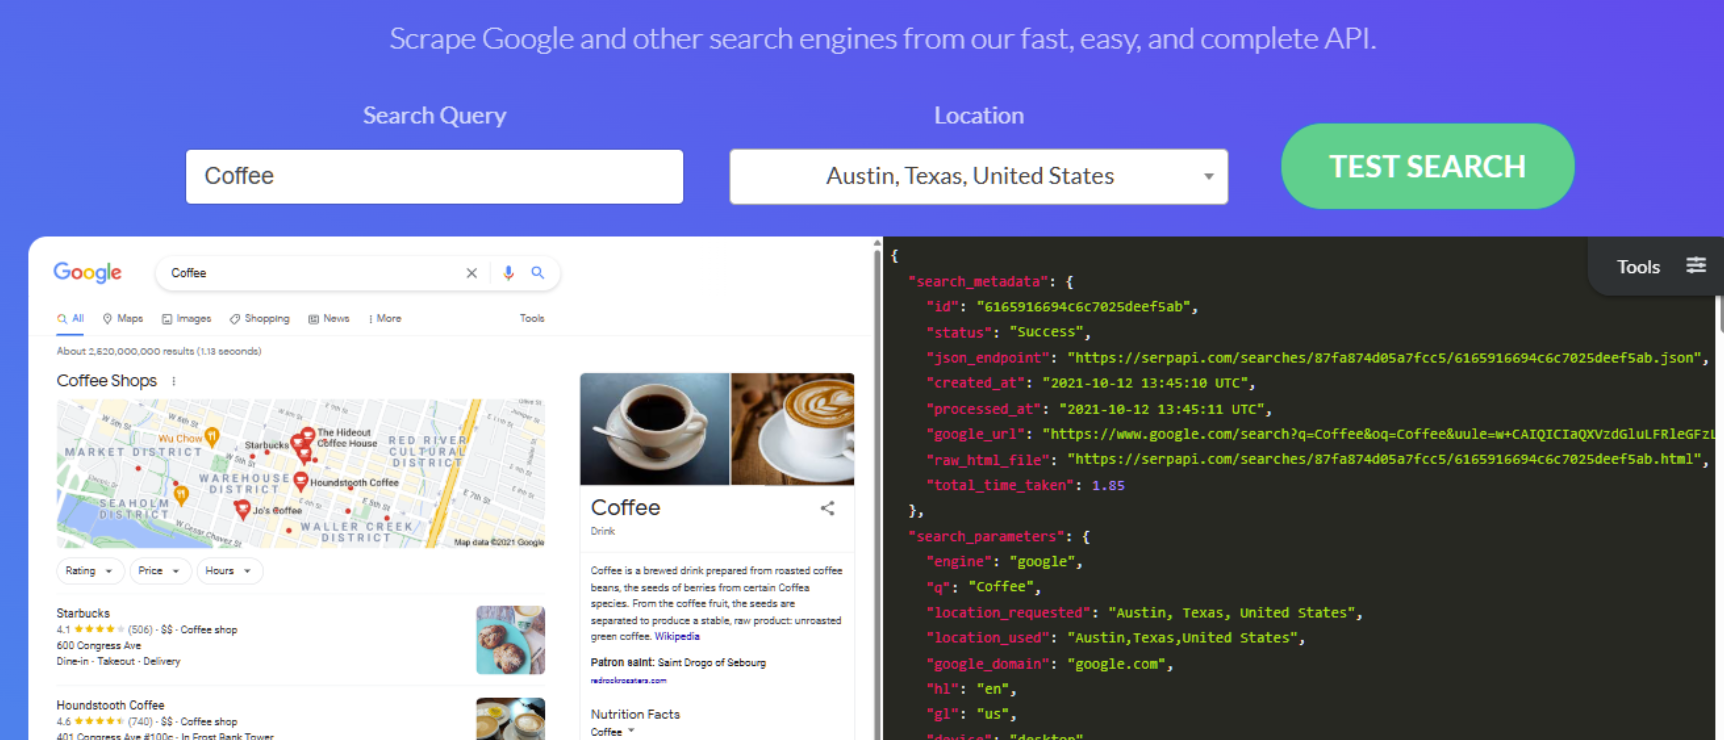

In [21]:
#%pip install langchain-google-genai

In [22]:
#from langchain import SerpAPIWrapper
#
#search = SerpAPIWrapper(serpapi_api_key=os.environ["SERP_API_KEY"])
#
### 4. Create the Agent
### Get a default ReAct prompt template
### You might need to install langchainhub: pip install langchainhub
##react_prompt = hub.pull("hwchase17/react")
#
## tools
#google_tools = [
#    Tool(
#        name="Intermediate Answer",
#        func=search.run,
#        description="Search google to get useful information"
#    )
#]

In [23]:
## initialize our agent
#google_search_agent = initialize_agent(
#    tools=google_tools,
#    llm=openai_llm,
#    agent="self-ask-with-search",
#    handle_parsing_errors=True,
#    verbose=True,
#    max_iterations=3 # to avoid high bills from the LLM
#)
#
#query = """Who is Mehdi Rezvandehy on the web and how many publications does he/she have?"""
#result = google_search_agent(query)

In [38]:
import json
import os
import requests
from langchain.tools import tool
from langchain.tools import BaseTool
from serpapi import GoogleSearch

class GoogleSearchTool(BaseTool):
    name: str = "Google Search"
    description: str = """Searches the internet for a given topic and returns relevant results."""

    def _run(self, query: str, top_k: int = 3) -> str:
        params = {
            "engine": "google",
            "google_domain": "google.com",
            "gl": "us",
            "hl": "en",
            "q": query,
            "api_key": os.environ["SERP_API_KEY"],
        }

        search = GoogleSearch(params)
        response = search.get_dict()
        
        # Check if organic results are available, exclude sponsored results
        if 'organic_results' not in response:
            return "Sorry, I couldn't find anything on that topic. There may be an issue with your SerpApi key."
        
        results = response['organic_results']
        formatted_results = []
        
        for result in results[:top_k]:
            try:
                formatted_results.append('\n'.join([
                    f"Title: {result['title']}", 
                    f"Link: {result['link']}",
                    f"Snippet: {result['snippet']}", 
                    "\n-----------------"
                ]))
            except KeyError:
                continue

        return '\n'.join(formatted_results)

In [45]:
from langchain.agents import initialize_agent
from langchain.chat_models import ChatOpenAI
from langchain.tools import tool
from bs4 import BeautifulSoup
import requests
import re

@tool
def scrape_and_extract_website(input_str: str) -> str:
    """
    Given a user's full query, apply google search
    and answer the question using the search.
    """
    print("INPUT TO TOOL:", input_str)
    # Extract URL
    google_content = GoogleSearchTool().run(input_str)

    prompt = f"""You are a google search assistant.
Use the following google content to answer the user's google search.

User's google search:
{input_str}

google content:
{google_content}

"""
    print(prompt)
    return openai_llm.predict(prompt)

# Initialize agent
google_search_agent = initialize_agent(
    tools=[scrape_and_extract_website],
    llm=openai_llm,
    agent="zero-shot-react-description",
    max_iterations=5, # to avoid high bills from the LLM
    verbose=True
)

# Full query should now be passed to the tool
#result = webpage_reader_agent('Summarize in 4–5 bullet points the top headlines from https://bbc.com/news published \
#                              within the past ~10 hours.')
#
result = google_search_agent('Who is Mehdi Rezvandehy on the web, name of companies he has worked?')

print(result)




> Entering new AgentExecutor chain...
I can use the scrape_and_extract_website tool to search for information about Mehdi Rezvandehy and the companies he has worked for.
Action: scrape_and_extract_website
Action Input: "Mehdi Rezvandehy companies worked for"INPUT TO TOOL: Mehdi Rezvandehy companies worked for
You are a google search assistant.
Use the following google content to answer the user's google search.

User's google search:
Mehdi Rezvandehy companies worked for

google content:
Title: Contact Mehdi Rezvandehy, Email - ATB Financial
Link: https://www.zoominfo.com/p/Mehdi-Rezvandehy/2227598116
Snippet: Mehdi Rezvandehy is a Principal Data Scientist at ATB Financial, bringing expertise in applying Large Language Models (LLM) and Generative AI to analyze ...

-----------------
Title: Mehdi Rezvandehy - Principal Data Scientist at ATB Financial
Link: https://theorg.com/org/atb-financial/org-chart/mehdi-rezvandehy
Snippet: Mehdi began a professional journey as a Geophysicist at D

In [46]:
print(result['output'])

Mehdi Rezvandehy has worked for ATB Financial as a Principal Data Scientist and Dana Energy Company as a Geophysicist.


## webpage_reader_agent

Here is a LangChain's agent to read a webpage from URLs and retrieve requested information.

In [27]:
from langchain.agents import initialize_agent
from langchain.chat_models import ChatOpenAI
from langchain.tools import tool
from bs4 import BeautifulSoup
import requests
import re


@tool
def scrape_and_extract_website(input_str: str) -> str:
    """
    Given a user's full query (including a question and a URL), scrape the page
    and answer the question using the webpage content.
    """
    print("INPUT TO TOOL:", input_str)
    # Extract URL
    url_match = re.search(r'https?://\S+', input_str)
    if not url_match:
        return "No valid URL found in the input."

    url = url_match.group(0)
    question = input_str.replace(url, "website").strip()

    try:
        soup = BeautifulSoup(requests.get(url).text, "html.parser")
        clean_text = re.sub(r'\s+', ' ', soup.get_text()).strip()[:10000]

    except Exception as e:
        return f"Failed to scrape the URL: {e}"

    prompt = f"""You are a website assistant.
Use the following webpage content to answer the user's question.

User's question:
{question}

Webpage text:
{clean_text}
"""
    print(prompt)
    return openai_llm.predict(prompt)

# Initialize agent
webpage_reader_agent = initialize_agent(
    tools=[scrape_and_extract_website],
    llm=openai_llm,
    agent="zero-shot-react-description",
    verbose=True
)

# Full query should now be passed to the tool
#result = webpage_reader_agent('Summarize in 4–5 bullet points the top headlines from https://bbc.com/news published \
#                              within the past ~10 hours.')
#
result = webpage_reader_agent('Check the documentation at https://pytorch.org and tell me the latest version name.')

print(result)




> Entering new AgentExecutor chain...
I need to scrape the PyTorch website to find the latest version name.
Action: scrape_and_extract_website
Action Input: "What is the latest version of PyTorch? https://pytorch.org"INPUT TO TOOL: What is the latest version of PyTorch? https://pytorch.org
You are a website assistant.
Use the following webpage content to answer the user's question.

User's question:
What is the latest version of PyTorch? website

Webpage text:
PyTorch Skip to main content github Join us at PyTorch Conference in San Francisco, October 22-23. Register now! Hit enter to search or ESC to close Close Search search Menu Learn Get Started Tutorials Learn the Basics PyTorch Recipes Intro to PyTorch – YouTube Series Webinars Community Landscape Join the Ecosystem Community Hub Forums Developer Resources Contributor Awards Community Events PyTorch Ambassadors Projects PyTorch vLLM DeepSpeed Host Your Project Docs PyTorch Domains Blog & News Blog Announcements Case Studies Even

In [28]:
result = webpage_reader_agent('Summarize the key findings from the latest IPCC report available on their website.')

print(result)



> Entering new AgentExecutor chain...
I should use the scrape_and_extract_website tool to gather information from the IPCC website.
Action: scrape_and_extract_website
Action Input: "Summarize the key findings from the latest IPCC report available on their website" https://www.ipcc.ch/INPUT TO TOOL: Summarize the key findings from the latest IPCC report available on their website" https://www.ipcc.ch/
You are a website assistant.
Use the following webpage content to answer the user's question.

User's question:
Summarize the key findings from the latest IPCC report available on their website" website

Webpage text:
IPCC — Intergovernmental Panel on Climate Change Menu About Data Documentation Focal Points Portal Bureau Portal Library Links Help Languages عربي 简体中文 Français Русский Español Search Reports Synthesis Report Working Groups Activities News Calendar Follow Share Special and Methodology Reports 2027 IPCC Methodology Report on Inventories for Short-lived Climate Forcers Specia


Observation: The key findings from the latest IPCC report available on their website include the Sixth Assessment Report (AR6) which consists of three Working Group contributions and a Synthesis Report. The Working Group I contribution was finalized in August 2021, the Working Group II contribution in February 2022, the Working Group III contribution in April 2022, and the Synthesis Report in March 2023. The report provides comprehensive information on the state of scientific, technical, and socio-economic knowledge on climate change, its impacts, future risks, and options for reducing the rate of climate change.
Thought:I have gathered the necessary information to summarize the key findings from the latest IPCC report.
Final Answer: The key findings from the latest IPCC report include the Sixth Assessment Report (AR6) consisting of three Working Group contributions and a Synthesis Report, providing comprehensive information on climate change, its impacts, future risks, and options fo

## python_repl_agent

LangChain's agent to execute a Python code snippets to find solutions and shows the underlying code.

In [29]:
from langchain.agents import initialize_agent, AgentType
from langchain.chat_models import ChatOpenAI
from langchain_experimental.tools.python.tool import PythonREPLTool

# Initialize the Python REPL tool
python_repl_tool = PythonREPLTool(name='Python_REPL',
                                  description= 'A Python shell. Use this to execute python commands. \
                                  Input should be a valid python command. If you want to see the \
                                  output of a value, you should print it out with `print(...)`.',
                                  return_direct = False,
                                  verbose = True)

# Create the agent with the Python REPL tool
python_repl_agent = initialize_agent(
    tools=[python_repl_tool],
    llm=openai_llm,
    agent="zero-shot-react-description",
    verbose=True
)

# Run an example
response = python_repl_agent.run("Write a function in Python to convert 42 kilometers to miles")
print(response)



> Entering new AgentExecutor chain...


Python REPL can execute arbitrary code. Use with caution.


I need to write a function that takes kilometers as input and converts it to miles using the conversion factor 0.621371.
Action: Python_REPL
Action Input: 
def km_to_miles(km):
    return km * 0.621371

print(km_to_miles(42))
Observation: 26.097582

Thought:The function successfully converted 42 kilometers to miles.
Final Answer: 26.097582 miles

> Finished chain.
26.097582 miles


In [30]:
# Run an example
response = python_repl_agent.run('print(6+2)')
print(response)



> Entering new AgentExecutor chain...
This is a simple math operation that can be done in Python.
Action: Python_REPL
Action Input: print(6+2)
Observation: 8

Thought:The result of 6+2 is 8.
Final Answer: 8

> Finished chain.
8


In [31]:
response = python_repl_agent.run('Create a Python dictionary where the keys are the letters "a", "b", and "c", and the values are their ASCII codes. Print the dictionary.')
print(response)



> Entering new AgentExecutor chain...
I can use a dictionary comprehension to create this dictionary.
Action: Python_REPL
Action Input: ascii_dict = {letter: ord(letter) for letter in ['a', 'b', 'c']}
Observation: 
Thought:I have created the dictionary with the ASCII codes for the letters "a", "b", and "c".
Final Answer: ascii_dict

> Finished chain.
ascii_dict


## url_pdf_retriever_agent

Here is a LangChain's agent to visit PDF of the given URL and answer the requested question.

In [35]:
import os
import requests
from langchain.agents import initialize_agent, Tool
from langchain.llms import OpenAI
from langchain.document_loaders import CSVLoader, PyPDFLoader
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.agents.react.base import DocstoreExplorer
from langchain.vectorstores import FAISS
from langchain.chains import RetrievalQA
#from langchain_google_vertexai import VertexAIEmbeddings
from typing import List
import tempfile
import time

#embeddings = VertexAIEmbeddings(
#    model_name="text-embedding-005", project='pd-deep-sat-05')
embeddings = OpenAIEmbeddings()

class DocstoreExplorer:
    def __init__(self, llm):
        self.llm = llm
        self.vectorstore = None
        self.loaded_files = []  # Keep track of loaded files

    def _download_file(self, url: str) -> str:
        """Downloads a file from a URL to a temporary location."""
        max_retries = 1
        retry_delay = 1  # seconds
        try:
            for attempt in range(max_retries):
                try:
                    response = requests.get(url, stream=True)
                    response.raise_for_status()  # Raise an exception for bad status codes
                    suffix = ""
                    if url.lower().endswith(".csv"):
                        suffix = ".csv"
                    elif url.lower().endswith(".pdf"):
                        suffix = ".pdf"
                    else:
                        raise ValueError(f"Unsupported file type from URL: {url}")

                    with tempfile.NamedTemporaryFile(delete=False, suffix=suffix) as tmp_file:
                        for chunk in response.iter_content(chunk_size=8192):
                            tmp_file.write(chunk)
                        return tmp_file.name
                    break  # Exit the loop if successful

                except requests.exceptions.RequestException as e:
                    print(f"Attempt {attempt + 1} failed: {e}")
                    if attempt < max_retries - 1:
                        print(f"Retrying in {retry_delay} seconds...")
                        time.sleep(retry_delay)
                    else:
                        print("Max retries reached. Unable to download the PDF.")

        except requests.exceptions.RequestException as e:
            raise Exception(f"Error downloading file from {url}: {e}")
        return "Document downloaded successfully."

    def load_files_from_urls(self, file_url: str):
        """
        Loads and processes CSV and PDF files from the given URLs.

        Args:
            file_urls (str): A URL to a CSV or PDF file.
        """
        documents = []
        local_files = []
        try:
            print(f"Downloading file from: {file_url}")  # ADDED THIS LINE
            local_path = self._download_file(file_url)
            local_files.append(local_path)
            if local_path.lower().endswith(".pdf"):
                print(f"loading file from path: {local_path}")
                loader = PyPDFLoader(file_path=local_path)
                documents.extend(loader.load_and_split())
            elif local_path.lower().endswith(".csv"):
                print(f"loading file from path: {local_path}")
                loader = CSVLoader(file_path=local_path)
                documents.extend(loader.load())
            else:
                print(f"Skipping unsupported file type: {file_url}")
            if not documents:  # Check if any valid documents were loaded
                raise ValueError("No valid PDF or CSV files found in the provided URL.")
            if self.vectorstore is None:
                self.vectorstore = FAISS.from_documents(documents, embeddings)
            else:
                self.vectorstore.add_documents(documents) # Add new documents to existing vectorstore
            self.loaded_files.append(file_url) # Track loaded file
        finally:
            # Clean up temporary files
            for file_path in local_files:
                try:
                    os.remove(file_path)
                except OSError as e:
                    print(f"Error deleting temporary file {file_path}: {e}")
        return "Document loaded successfully. You can now query the document using the Lookup tool."

    def query_docstore(self, query: str):
        """
        Queries the loaded documents using similarity search.

        Args:
            query (str): The query string.

        Returns:
            str: The answer to the query.
        """
        if self.vectorstore is None:
            return "I need to load a document first using the Search tool with a file URL."

        qa = RetrievalQA.from_chain_type(
            llm=self.llm,
            chain_type="stuff",  # Use "stuff" or other appropriate chain type
            retriever=self.vectorstore.as_retriever(),
            verbose=True,  # Enable for debugging
        )
        return qa.run(query)

    def reset_docstore(self):
        """Resets the vectorstore and loaded files."""
        self.vectorstore = None
        self.loaded_files = []
        print("DocstoreExplorer has been reset.")

"""
Creates a LangChain agent with the DocstoreExplorer tool for loading from URLs.

Args:
    llm: The language model to use.

Returns:
    initialize_agent: The initialized LangChain agent.
"""
docstore_explorer = DocstoreExplorer(openai_llm)

Lookup = Tool(
    name="Lookup",
    func=docstore_explorer.query_docstore,
    description="Query the loaded document. Use this tool to ask question about the file.",
)
#
Search = Tool(
    name="Search",
    func=docstore_explorer.load_files_from_urls,
    description="Loads a PDF file from a URL. The input should be a single URL. Once the document is loaded successfully, you can use the Lookup tool to ask questions about it.",
)

Reset = Tool(
        name="Reset",
        func=docstore_explorer.reset_docstore,
        description="Resets the document store, clearing loaded files and the vectorstore. Use this to start with a clean slate.",
)

# Use a modern agent, e.g., chat agent
url_pdf_retriever_agent = initialize_agent(
    tools=[Search, Lookup, Reset],
    llm=openai_llm,
    agent="zero-shot-react-description",
    memory=None,  # You can add memory here if needed
    verbose=True,
    handle_parsing_errors=True,
)


# Example usage:
file_url = "https://www.nj.gov/humanservices/dmhas/publications/miscl/MH_Fact_Sheets/NIMH_Depression.pdf"

#  IMPORTANT:  Structure the interaction as distinct steps.
response = url_pdf_retriever_agent.run(f"First, use the Search tool to load this pdf: {file_url}. \
Then, summarize the document in 3-4 sentences using the Lookup tool.")  # Load the files first
print(response)



> Entering new AgentExecutor chain...
I need to use the Search tool to load the PDF file provided before I can summarize it using the Lookup tool.
Action: Search
Action Input: https://www.nj.gov/humanservices/dmhas/publications/miscl/MH_Fact_Sheets/NIMH_Depression.pdfDownloading file from: https://www.nj.gov/humanservices/dmhas/publications/miscl/MH_Fact_Sheets/NIMH_Depression.pdf
loading file from path: C:\Users\mrezv\AppData\Local\Temp\tmp45s8yblp.pdf

Observation: Document loaded successfully. You can now query the document using the Lookup tool.
Thought:Now I can use the Lookup tool to summarize the document in 3-4 sentences.
Action: Lookup
Action Input: Summarize the document

> Entering new RetrievalQA chain...

> Finished chain.

Observation: The document is a publication from the National Institute of Mental Health providing information on depression. It includes resources for more information on depression, such as websites and contact information. The document also offers a

# Agent Selection Prompt Design

In this section, we present a framework to evaluate how effectively a large language model (LLM) can select the correct specialized agent to handle a given user question. We simulate a **manager agent** that routes each question to the most appropriate tool from a predefined list. The core objective is to assess the LLM’s ability to reason about tool usage based on natural language queries, as well as to investigate the presence of **positional bias** in its decision-making.

* **Agents Overview**

The agents, all implemented using the LangChain framework (introduced in the previous section), include:

* `webpage_reader_agent`: Scrapes or summarizes information from a provided URL.
* `math_agent`: Performs numerical or symbolic mathematical calculations.
* `python_repl_agent`: Executes Python code to solve logic or computation-based tasks.
* `url_pdf_retriever_agent`: Extracts content from a PDF accessible via URL to answer questions.
* `google_search_agent`: Finds current or real-time information from the internet.

Each agent is assigned **10 benchmark questions** aligned with its intended functionality. The following is a sample prompt used to query the LLM:

```python
You are a manager agent that decides which tool to use based on the question.

Available tools:
  - webpage_reader_agent: Visits and scrapes or summarizes content from given URLs
  - math_agent: Handles math-related calculations and functions
  - python_repl_agent: Executes Python code snippets to find solutions and shows the underlying code.
  - url_pdf_retriever_agent: Visit PDF of the given URLs and answer the question
  - google_search_agent: Find current or real-time information on the Internet

Choose the correct tool for this question: 
"According to https://en.wikipedia.org/wiki/Artificial_intelligence, find information on the latest AI advancements"

Only output the name of the best tool (e.g., math_agent, webpage_reader_agent, etc.)
```


The model’s output is compared to ground truth agent labels based on question intent. Performance is evaluated using the following metrics:

* **Precision**: For each agent, the ratio of correctly selected cases (true positives) to all cases where the agent was chosen (true positives + false positives).

* **Recall**: For each agent, the ratio of correctly selected cases (true positives) to all cases where the agent *should* have been chosen (true positives + false negatives).

* **Overall Accuracy**: The proportion of all questions where the LLM correctly selected the intended agent.

These metrics help identify whether the LLM can not only route questions accurately, but also avoid overusing certain agents incorrectly (high precision) and avoid missing opportunities where a given agent should have been used (high recall).


To assess **positional bias**, we systematically shuffle the order of the listed tools in the prompt across multiple runs. By observing changes in agent selection patterns relative to their position in the list, we measure whether the LLM disproportionately favors agents that appear earlier in the tool list.


In [37]:
tool_selection_test_data = [
   # math_agent
   ('List the first 10 even numbers?', math_agent),
   ("What is the ASCII code for the letter 'a'", math_agent),
   ('If you were to pick a random integer between 1 and 10, what might one possibility be?', math_agent),
   ('How many days are in June 2025?', math_agent),
   ('If you take the cosine of pi over three and add one, what is that result raised to the power of two point two?', math_agent),
   ('What is the product of all positive integers up to one hundred and twelve?', math_agent),
   ('What is the equivalent temperature in Celsius if it is fifty-nine point three five degrees Fahrenheit?', math_agent),
   ('What is the result of (sin(𝜋/6.364)+cos(𝜋*1.7))**1.9?', math_agent),
   ('What is the result of log(4750)**2.64. Print calculation?', math_agent),
   ('How many miles are there in sixty-two point four six kilometers?', math_agent),

   # webpage_reader_agent
   ('Go to https://www.cnn.com and tell me the main headlines', webpage_reader_agent),
   ('Find information about the latest advancements in AI by browsing https://openai.com/blog/', webpage_reader_agent),
   ('Based on the guidelines provided in document at https://www.canada.ca/content/dam/phac-aspc/migration/phac-aspc/hp-ps/alt/iyh-vsv-2024-eng, \
    what are the recommended daily intakes of Vitamin D for adults?', webpage_reader_agent),
   ('Scrape the contact information from https://www.tesla.com/contact.', webpage_reader_agent),
   ('Visit https://techcrunch.com/events/ and tell me about the next three conferences.', webpage_reader_agent),
   ('What are people saying about the new electric vehicle on https://www.caranddriver.com/?', webpage_reader_agent),
   ('Browse https://www.canada.ca/en/services/business/main.html and find the current guidelines for small businesses.', webpage_reader_agent),
   ('Get the list of ingredients from https://www.allrecipes.com/recipe/158969/one-bowl-chocolate-cake-iii/.', webpage_reader_agent),
   ('According to https://www.treehugger.com/, what are the key information about sustainable living?', webpage_reader_agent),
   ('Read the Wikipedia page for "Artificial Intelligence" at https://en.wikipedia.org/wiki/Artificial_intelligence and give me a brief overview.', webpage_reader_agent),

   # google_search_agent 
   ('What is the population of Tokyo right now?', google_search_agent),
   ('Where are some good places to hike near Banff National Park?', google_search_agent),
   ('Can you find Yann LeCun s professional page?', google_search_agent),
   ('When will we see the next eclipse in Calgary?', google_search_agent),
   ('Who got the Nobel Prize for physics last year?', google_search_agent),
   ('What are some interesting places tourists like to visit in Rome?', google_search_agent),
   ('What is the current value of Canadian money compared to European money?', google_search_agent),
   ('What were the top-selling books last year according to the New York Times?', google_search_agent),
   ('What does "AI" mean?', google_search_agent),
   ('Look up the conversion from 102 degrees Fahrenheit to Celsius on the web?', google_search_agent),

   # url_pdf_retriever_agent
   ('From the document at https://www.wipo.int/edocs/pubdocs/en/wipo_pub_945_2020/wipo_pub_945_2020.pdf, \
    identify the clauses related to intellectual property rights.', url_pdf_retriever_agent),
   ('Go to the document found at https://www.cs.ubc.ca/~poole/cs322/2023/syllabus.pdf and list the \
    required textbooks for the Introduction to Artificial Intelligence course.', url_pdf_retriever_agent),
   ('Based on the guidelines at https://www.canada.ca/content/dam/phac-aspc/migration/phac-aspc/hp-ps/alt/iyh-vsv-2024-eng.pdf,\
    what are the recommended daily intakes of Vitamin D for adults?', url_pdf_retriever_agent),
   ('Access the document at https://www.archives.gov/founding-fathers/declaration/download \
    and transcribe the opening paragraph of the text.', url_pdf_retriever_agent ),
   ('Get the list of ingredients from the recipe webpage at https://www.allrecipes.com/recipe/17588/simple-chocolate-cake.pdf.', url_pdf_retriever_agent),
   ('Find the recipe available at https://www.allrecipes.com/recipe/17588/simple-chocolate-cake.pdf and \
    extract the list of ingredients required for Simple Chocolate Cake', url_pdf_retriever_agent),
   ('Analyze the document at https://www.nserc-crsng.gc.ca/Professors-Professeurs/RPP-PP/AGF-FGA_eng.pdf \
    and identify the eligibility criteria for applicants', url_pdf_retriever_agent),
   ('Summarize the contents of the document located at \
    https://www.nj.gov/humanservices/dmhas/publications/miscl/MH_Fact_Sheets/NIMH_Depression.pdf', url_pdf_retriever_agent),
   ('Extract the table of contents from \
    https://www.afdb.org/sites/default/files/documents/publications/african_economic_outlook_2024_en.pdf', url_pdf_retriever_agent),
   ('What are the key recommendations outlined in the report available at https://www.who.int/publications/i/item/9789240038379.pdf', url_pdf_retriever_agent),
    
    #python_repl_agent
   ('What is the square root of pi, calculated with 5 decimal places using Python?', python_repl_agent),
   ('Write a Python function to reverse a string and apply it to the string "hello world", then print the result.', python_repl_agent),
   ('Calculate the number of seconds in a leap year using datetime and timedelta objects, and print the answer.', python_repl_agent),
   ('Define a Python list with the numbers 1 to 5, then write code to calculate their average and print the result.', python_repl_agent),
   ('Using math module, calculate the natural logarithm of 20 and print the output.', python_repl_agent),
   ('Write a Python conditional statement that checks if the number 17 is prime and prints "Prime" or "Not Prime".', python_repl_agent),
   ('Create a dictionary where the keys are the letters "a", "b", and "c", and the values are their ASCII codes.', python_repl_agent),
   ('Write a list comprehension to generate a list of the first 10 even numbers, then print the list.', python_repl_agent),
   ('Generate a random integer between 1 and 10 (inclusive) using random module and print it.', python_repl_agent),
   ('Import the calendar module in Python and print the calendar for June 2025', python_repl_agent),
    
]

tools_to_pick_from = [math_agent, webpage_reader_agent, google_search_agent, url_pdf_retriever_agent, python_repl_agent]

In [39]:
# Example
prompt = """
You are a manager agent that decides which tool to use based on the question.

Available tools:
  - webpage_reader_agent: Visits and scrapes or summarizes content from given URLs
  - math_agent: Handles math-related calculations and functions
  - python_repl_agent: Executes Python code snippets to find solutions and shows the underlying code.
  - url_pdf_retriever_agent: Visit PDF of the given URLs and answer the question
  - google_search_agent: Find current or real-time information on the internet
  

Choose the correct tool for this question: "According to https://en.wikipedia.org/wiki/Artificial_intelligence, find information on the latest AI advancements"
    Only output the name of the best tool (e.g., math_agent, webpage_reader_agent, etc.)
"""
openai_llm.invoke(prompt).content.strip()

'webpage_reader_agent'

In [41]:
import random
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from collections import defaultdict
import numpy as np
from tqdm import tqdm

In [42]:
llm_list = []

llm_models = [#'gemini-2.0-flash-001',  # Latest stable version of Gemini 2.0 Flash
                 #'gemini-2.0-flash-lite-001', #Latest stable version of Gemini 2.0 Flash Lite
                 'gpt-3.5-turbo', # Openai
                 #'gemini-2.5-flash-preview-04-17', # Preview Models (Recommended for prototyping use cases only):
                 #'gemini-2.5-pro-preview-05-06' # Preview Models (Recommended for prototyping use cases only):
                ]

for i_llm in llm_models:
    if re.search('gemini', i_llm):
        llm = ChatVertexAI(
            model=i_llm,
            temperature=0.2,
            top_p=0.8,
            top_k=5,
            max_retries=6,
            stop_sequences=["STOP!"],
            max_output_tokens=10  # Example: limit to 100 tokens
        )
    if re.search('gpt', i_llm):
        llm = ChatOpenAI(temperature=0.2, model=i_llm)
        
    
    
    llm_list.append(llm)

In [44]:
%time
import random
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Tools and their names/descriptions
tool_objects = [
    ('math_agent', math_agent, 'Handles math-related calculations only'),
    ('webpage_reader_agent', webpage_reader_agent, 'Retrieves webpage content from URLs.'),
    ('google_search_agent', google_search_agent, 'Find current or real-time information on the internet'),
    ('url_pdf_retriever_agent', url_pdf_retriever_agent, 'Visit PDF of the given URL and answer the question'),
    ('python_repl_agent', python_repl_agent, 'Executes Python code snippets to find solutions and shows the underlying code.'),

]

tool_name_map = {id(obj): name for name, obj, _ in tool_objects}


# Function to construct prompt dynamically based on shuffled tools
def build_prompt(question, tool_list):
    tool_descriptions = "\n".join([f"- {name}: {desc}" for name, _, desc in tool_list])
    prompt = f"""
    You are a manager agent that decides which tool to use based on the question.

    Available tools:
    {tool_descriptions}

    Choose the correct tool for this question: "{question}"

    Only output the name of the best tool (e.g., math_agent, webpage_reader_agent, etc.)
    """
    return prompt.strip()

# LLM tool selector
def llm_pick_tool(openai_llm, tools, question):
    prompt = build_prompt(question, tools)
    #print(prompt)
    #response = llm.predict(prompt)
    #return response.strip()
    text = openai_llm.invoke(prompt).content.strip()

    return text

# Evaluation
all_question = []
all_predictions = []
all_labels = []
all_tool_names = []
all_true_idx = []
all_pred_idx = []
all_llm = []
n_trials = 50

print(f"Evaluating agent routing over {n_trials} trials...\n")
for trial in tqdm(range(n_trials), desc="Trials"):
    data = tool_selection_test_data[:]
    random.shuffle(data)
    for llm, model_name in zip(llm_list, llm_models):
        #print(model_name)
        for question, correct_tool in data:
            shuffled_tools = tool_objects[:]
            random.shuffle(shuffled_tools)
    
            tmp_tool_names = [name for name, _, desc in shuffled_tools]
            all_tool_names.append(tmp_tool_names)
            true_tool_name = tool_name_map[id(correct_tool)]
            predicted_tool_name = llm_pick_tool(llm, shuffled_tools, question)
            all_question.append(question)
            idx_true = tmp_tool_names.index(true_tool_name)
            all_true_idx.append(idx_true)
            idx_pred = tmp_tool_names.index(predicted_tool_name)
            all_pred_idx.append(idx_pred)
            all_labels.append(true_tool_name)
            all_predictions.append(predicted_tool_name)
            all_llm.append(model_name)

# Metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='macro', zero_division=0)

print(f"\n✅ Evaluation Results (over {n_trials} trials):")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision (macro): {precision:.2f}")
print(f"Recall (macro): {recall:.2f}")
print(f"F1 Score (macro): {f1:.2f}")

CPU times: total: 0 ns
Wall time: 0 ns
Evaluating agent routing over 50 trials...



Trials: 100%|██████████████████████████████████████████████████████████████████████████| 50/50 [17:24<00:00, 20.88s/it]


✅ Evaluation Results (over 50 trials):
Accuracy: 0.87
Precision (macro): 0.89
Recall (macro): 0.87
F1 Score (macro): 0.87


# Evaluate LLM for Agent Selection Prompt

In [67]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support

## Confusion Metrics 

In [72]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

df_eval_agent = pd.DataFrame()
df_eval_agent['all_llm'] = all_llm
df_eval_agent['question'] = all_question
df_eval_agent['tool_names'] = all_tool_names
df_eval_agent['label'] = all_labels
df_eval_agent['label_idx'] = all_true_idx
df_eval_agent['pred'] = all_predictions
df_eval_agent['pred_idx'] = all_pred_idx

In [73]:
df_eval_agent.to_csv('positinal_embedding.csv', index=False)  

In [75]:
df_eval_agent[:4]

,all_llm,question,tool_names,label,label_idx,pred,pred_idx
0,gpt-3.5-turbo,"If you were to pick a random integer between 1 and 10, what might one possibility be?","[url_pdf_retriever_agent, google_search_agent, python_repl_agent, webpage_reader_agent, math_agent]",math_agent,4,math_agent,4
1,gpt-3.5-turbo,Generate a random integer between 1 and 10 (inclusive) using random module and print it.,"[math_agent, python_repl_agent, webpage_reader_agent, google_search_agent, url_pdf_retriever_agent]",python_repl_agent,1,python_repl_agent,1
2,gpt-3.5-turbo,Summarize the contents of the document located at https://www.nj.gov/humanservices/dmhas/publications/miscl/MH_Fact_Sheets/NIMH_Depression.pdf,"[google_search_agent, python_repl_agent, url_pdf_retriever_agent, webpage_reader_agent, math_agent]",url_pdf_retriever_agent,2,url_pdf_retriever_agent,2
3,gpt-3.5-turbo,"If you take the cosine of pi over three and add one, what is that result raised to the power of two point two?","[math_agent, url_pdf_retriever_agent, webpage_reader_agent, python_repl_agent, google_search_agent]",math_agent,0,math_agent,0


In [137]:
#df_gemini_2_0_flash_lite_001 = df_eval_agent[df_eval_agent.all_llm=='gemini-2.0-flash-lite-001'].reset_index(drop=True)
#df_gemini_2_0_flash_001 = df_eval_agent[df_eval_agent.all_llm=='gemini-2.0-flash-001'].reset_index(drop=True)
df_gpt_3_5_turbo = df_eval_agent[df_eval_agent.all_llm=='gpt-3.5-turbo'].reset_index(drop=True)
#df_gemini_2_5_pro_preview = df_eval_agent[df_eval_agent.all_llm=='gemini-2.5-pro-preview-05-06'].reset_index(drop=True)
#df_gemini_2_5_flash_preview_04_17 = df_eval_agent[df_eval_agent.openai_llm=='gemini-2.5-flash-preview-04-17'].reset_index(drop=True)

In [76]:
pred = df_gpt_3_5_turbo['pred'] 
label = df_gpt_3_5_turbo['label']
#
accuracy = np.round(accuracy_score(label, pred)*100,1)
macro_averaged_precision = np.round(precision_score(label, pred, average = 'macro')*100,1)
micro_averaged_precision = np.round(precision_score(label, pred, average = 'micro')*100,1)
macro_averaged_recall = np.round(recall_score(label, pred, average = 'macro')*100,1)
micro_averaged_recall = np.round(recall_score(label, pred, average = 'micro')*100,1)

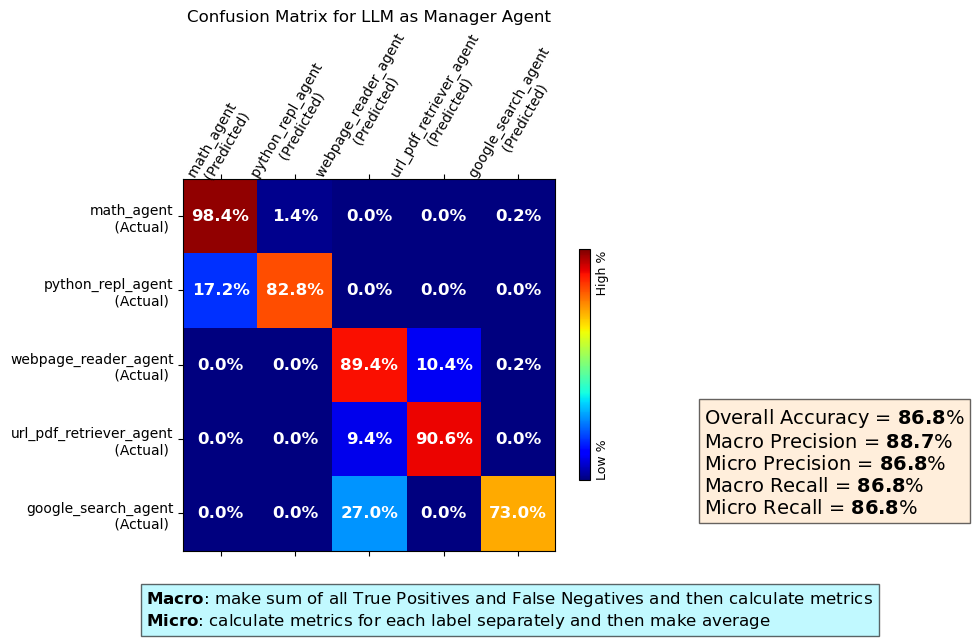

In [109]:
# Calculate the percentage
font = {'size'   : 9}
plt.rc('font', **font)
fig, ax=plt.subplots(figsize=(6, 5), dpi= 100, facecolor='w', edgecolor='k')

alllabels = [ 'math_agent','python_repl_agent','webpage_reader_agent',
             'url_pdf_retriever_agent','google_search_agent',]

per_cltr=np.zeros((len(alllabels), len(alllabels)))
for i in range(len(alllabels)):
    for j in range(len(alllabels)):
        per_cltr[i,j] = len(df_gpt_3_5_turbo[(df_gpt_3_5_turbo['label']==alllabels[i]) & 
        (df_gpt_3_5_turbo['pred']==alllabels[j])])/len(df_gpt_3_5_turbo[
            df_gpt_3_5_turbo['label']==alllabels[i]
        ])
    
cax =ax.matshow(per_cltr, cmap='jet', interpolation='nearest',vmin=0, vmax=1)
cbar=fig.colorbar(cax,shrink=0.6,orientation='vertical',label='Low %                                    High %')
cbar.set_ticks([])
#plt.title('Mismatch Percentage', fontsize=14,y=1.17)

for i in range(len(alllabels)):
    for j in range(len(alllabels)):
        c = per_cltr[i,j]*100
        ax.text(j, i, str(round(c,1))+'%', va='center',weight="bold", ha='center',fontsize=12,c='w')

columns=[f'{alllabels[i]} \n (Predicted) ' for i in range(5)] 
ax.set_xticks(np.arange(len(alllabels)))
ax.set_xticklabels(columns, fontsize=10, rotation=60, y=0.95)
columns=[f'{alllabels[i]}\n (Actual) ' for i in range(5)]  
ax.set_yticks(np.arange(len(alllabels)))
ax.set_yticklabels(columns, fontsize=10, rotation='horizontal')

plt.title('Confusion Matrix for LLM as Manager Agent', 
          fontsize=12, y=1.4)

txt = "Overall Accuracy = "+ r'$\mathbf{' + str(accuracy) + '}$%\n'
txt += "Macro Precision = "+ r'$\mathbf{' + str(macro_averaged_precision) + '}$%\n'
txt += "Micro Precision = "+ r'$\mathbf{' + str(micro_averaged_precision) + '}$%\n'
txt += "Macro Recall = "+ r'$\mathbf{' + str(macro_averaged_recall) + '}$%\n'
txt += "Micro Recall = "+ r'$\mathbf{' + str(micro_averaged_recall) + '}$%'

plt.text(6.5, 4, txt,rotation=0,color='k', ha = 'left',fontsize=14,bbox=dict(facecolor='#FFE4C4', alpha=0.6)) 


txt_def = r'$\mathbf{' + 'Macro' + '}$'+": make sum of all True Positives and False Negatives and then calculate metrics\n"
txt_def+= r'$\mathbf{' + 'Micro' + '}$'+": calculate metrics for each label separately and then make average"
plt.text(-1, 5.5, txt_def,rotation=0,color='k', ha = 'left',fontsize=12,bbox=dict(facecolor='#98F5FF', alpha=0.6)) 

plt.show()

The confusion metrics shows overall accuracy is high but it drops significantly for selecting `google_search_agent` and `python_repl_agent`: LLM has wrongly picked 27% of `google_search_agent` questions to `webpage_reader_agent`. Also, selected wrongly 17.2% of `python_repl_agent` to `math_agent`.

## Positional Bias 

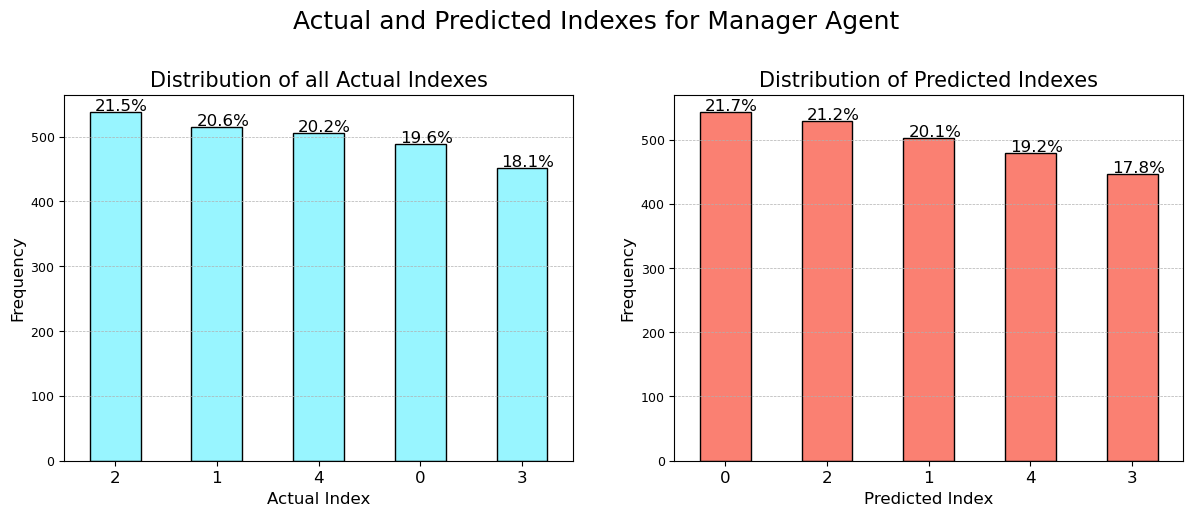

In [130]:
font = {'size': 9}
plt.rc('font', **font)

# Create figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), dpi=100)

# First bar plot
fre_idx = df_gpt_3_5_turbo.label_idx.value_counts()
percnt = fre_idx / sum(fre_idx) * 100
alllabels = fre_idx.index.tolist()

fre_idx.plot.bar(ax=ax1, color='#98F5FF', edgecolor='k')
ax1.set_title('Distribution of all Actual Indexes', fontsize=15)
ax1.set_xlabel('Actual Index', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_xticks(range(len(alllabels)))
ax1.set_xticklabels(alllabels, fontsize=12, rotation=0)
ax1.grid(axis='y', linestyle='--', linewidth=0.5)

for i, (freq, pct) in enumerate(zip(fre_idx, percnt)):
    ax1.text(i - 0.2, freq + 2, f'{pct:.1f}%', fontsize=12, color='k')

# Second bar plot
fre_idx2 = df_gpt_3_5_turbo.pred_idx.value_counts()
percnt2 = fre_idx2 / sum(fre_idx2) * 100
alllabels2 = fre_idx2.index.tolist()

fre_idx2.plot.bar(ax=ax2, color='salmon', edgecolor='k')
ax2.set_title('Distribution of Predicted Indexes', fontsize=15)
ax2.set_xlabel('Predicted Index', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_xticks(range(len(alllabels2)))
ax2.set_xticklabels(alllabels2, fontsize=12, rotation=0)
ax2.grid(axis='y', linestyle='--', linewidth=0.5)

for i, (freq, pct) in enumerate(zip(fre_idx2, percnt2)):
    ax2.text(i - 0.2, freq + 2, f'{pct:.1f}%', fontsize=12, color='k')

# Adjust layout
fig.tight_layout()
fig.subplots_adjust(wspace=0.2, top=0.85)
fig.suptitle('Actual and Predicted Indexes for Manager Agent', fontsize=18, y=1.02)

plt.show()

Figure above shows the most frequent predicted index by LLM is index 0 while the actual most frequent is agent 2. Next graph shows the indexes of wrongly selected agents.

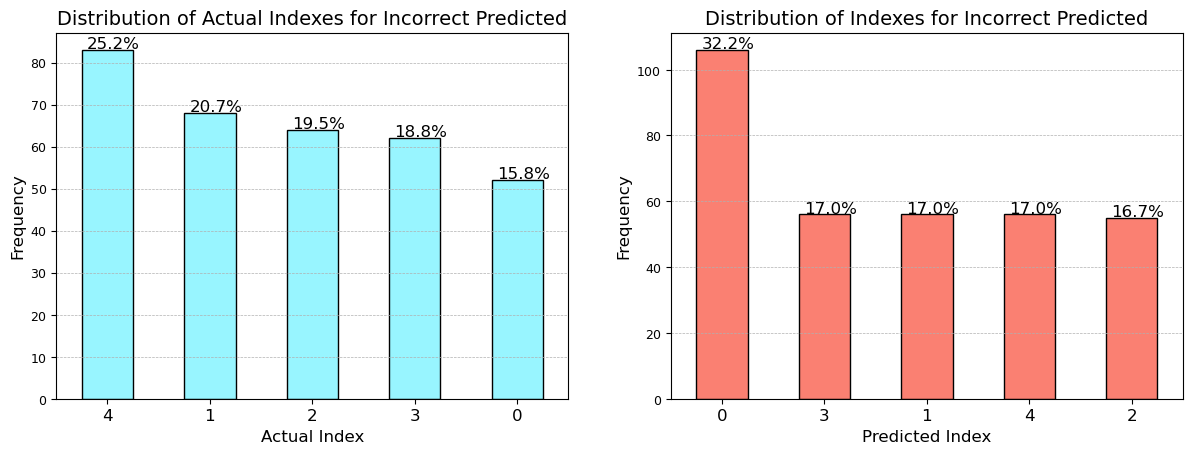

In [136]:
font = {'size': 9}
plt.rc('font', **font)

# Create figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), dpi=100)

# First bar plot
fre_idx = df_gpt_3_5_turbo[df_gpt_3_5_turbo.label!=df_gpt_3_5_turbo.pred].label_idx.value_counts()
percnt = fre_idx / sum(fre_idx) * 100
alllabels = fre_idx.index.tolist()

fre_idx.plot.bar(ax=ax1, color='#98F5FF', edgecolor='k')
ax1.set_title('Distribution of Actual Indexes for Incorrect Predicted', fontsize=14)
ax1.set_xlabel('Actual Index', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_xticks(range(len(alllabels)))
ax1.set_xticklabels(alllabels, fontsize=12, rotation=0)
ax1.grid(axis='y', linestyle='--', linewidth=0.5)

for i, (freq, pct) in enumerate(zip(fre_idx, percnt)):
    ax1.text(i - 0.2, freq + 0.5, f'{pct:.1f}%', fontsize=12, color='k')

# Second bar plot
fre_idx2 = df_gpt_3_5_turbo[df_gpt_3_5_turbo.label!=df_gpt_3_5_turbo.pred].pred_idx.value_counts()
percnt2 = fre_idx2 / sum(fre_idx2) * 100
alllabels2 = fre_idx2.index.tolist()

fre_idx2.plot.bar(ax=ax2, color='salmon', edgecolor='k')
ax2.set_title('Distribution of Indexes for Incorrect Predicted', fontsize=14)
ax2.set_xlabel('Predicted Index', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_xticks(range(len(alllabels2)))
ax2.set_xticklabels(alllabels2, fontsize=12, rotation=0)
ax2.grid(axis='y', linestyle='--', linewidth=0.5)

for i, (freq, pct) in enumerate(zip(fre_idx2, percnt2)):
    ax2.text(i - 0.2, freq + 0.5, f'{pct:.1f}%', fontsize=12, color='k')

# Adjust layout
fig.tight_layout()
fig.subplots_adjust(wspace=0.2, top=0.85)

plt.show()

The left graph displays the **actual indexes** of incorrectly selected agents. The most frequent error occurs at index 4, followed by indexes 1, 2, 3, and 0, in descending order. In contrast, the right graph shows that **index 0** is the most frequent among incorrect selections, indicating a clear **positional bias**—the model tends to favor agents listed earlier in the prompt, even when they are not the correct choice.

In [53]:
#df_math_agent = df_eval_agent[df_eval_agent.label=='math_agent'].reset_index(drop=True)
#df_webpage_reader_agent = df_eval_agent[df_eval_agent.label=='webpage_reader_agent'].reset_index(drop=True)
#df_url_pdf_retriever_agent = df_eval_agent[df_eval_agent.label=='url_pdf_retriever_agent'].reset_index(drop=True)
#df_google_search_agent = df_eval_agent[df_eval_agent.label=='google_search_agent'].reset_index(drop=True)

In [47]:
#df_google_search_agent[df_google_search_agent.label!=df_google_search_agent.pred].pred_idx.value_counts()

# Appendix

In [ ]:
#from langchain.agents import initialize_agent, Tool
#from langchain.chat_models import ChatOpenAI
#from bs4 import BeautifulSoup
#import requests
#
## Initialize the LLM
#model_chat = ChatOpenAI(temperature=0)
#
## Combined tool: scrape then extract
#def scrape_and_extract_headlines(url: str) -> str:
#    # Scrape
#    soup = BeautifulSoup(requests.get(url).text, "html.parser")
#    text = soup.get_text(separator="\n")
#
#    # Extract headlines
#    prompt = f"""You are a news bsite reader assistant.
#Given the following text from a news homepage, extract the top headlines.
#
#Text:
#{text}
#"""
#    return model_chat.predict(prompt)
#
## Register the combined tool
#headline_tool = Tool(
#    name="ScrapeAndExtractHeadlines",
#    func=scrape_and_extract_headlines,
#    description="Given a URL of a news homepage, scrape the content and extract top headlines."
#)
#
## Initialize agent with the one-step tool
#news_headline_agent = initialize_agent(
#    tools=[headline_tool],
#    llm=model_chat,
#    agent="zero-shot-react-description",
#    verbose=True,
#    max_iterations=2 # to avoid high bills from the LLM
#)
#
## Run the agent
#result = news_headline_agent("Get top headlines from https://bbc.com/news from ~10 hours ago in 4-5 bullet points")
#
#print(result['output'])